In [1]:
# !pip install earthengine-api
# !pip install geopandas
# !pip install geemap

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='ed2-metero-driver')

In [ ]:
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)
i_date = '2010-01-01'
f_date = '2010-12-31'

# Import the NASA MERRA land surface data collection.
slv = ee.ImageCollection('NASA/GSFC/MERRA/slv/2')
slv = slv.select('T10M',).filterDate(i_date, f_date)
# slv = slv.select('PS', 'QV10M', 'T10M', 'U50M', 'V50M').filterDate(i_date, f_date)

In [4]:
scale = 50000  # scale in meters

# lst_urban_point = lst.mean().sample(u_poi, scale).first().get('T10M').getInfo()
# print('Average daytime LST at urban point:', round(lst_urban_point -273.15, 2))


In [5]:
lst_u_poi = slv.getRegion(u_poi, scale).getInfo()

In [ ]:
# lst_u_poi[:]

[['id', 'longitude', 'latitude', 'time', 'T10M'],
 ['2022010100',
  4.7161552416274874,
  45.589500669065714,
  1640995200000,
  281.734619140625],
 ['2022010101',
  4.7161552416274874,
  45.589500669065714,
  1640998800000,
  281.4642639160156],
 ['2022010102',
  4.7161552416274874,
  45.589500669065714,
  1641002400000,
  281.1689758300781],
 ['2022010103',
  4.7161552416274874,
  45.589500669065714,
  1641006000000,
  280.6065979003906]]

In [6]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df


In [7]:
lst_df_urban = ee_array_to_df(lst_u_poi,['T10M'])

# save to csv file  
df = ee_array_to_df(lst_u_poi, ['T10M'])
df.to_csv('T10M_urbansite_2010.csv', index=False)

def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  t_modis-273.15 
    return t_celsius

# Apply the function to get temperature in celsius.
lst_df_urban['T10M'] = lst_df_urban['T10M'].apply(t_modis_to_celsius)

lst_df_urban.head()

,time,datetime,T10M
0,1262304000000,2010-01-01 00:00:00,6.309534
1,1262307600000,2010-01-01 01:00:00,6.276727
2,1262311200000,2010-01-01 02:00:00,6.280420
3,1262314800000,2010-01-01 03:00:00,6.308160
4,1262318400000,2010-01-01 04:00:00,6.075403


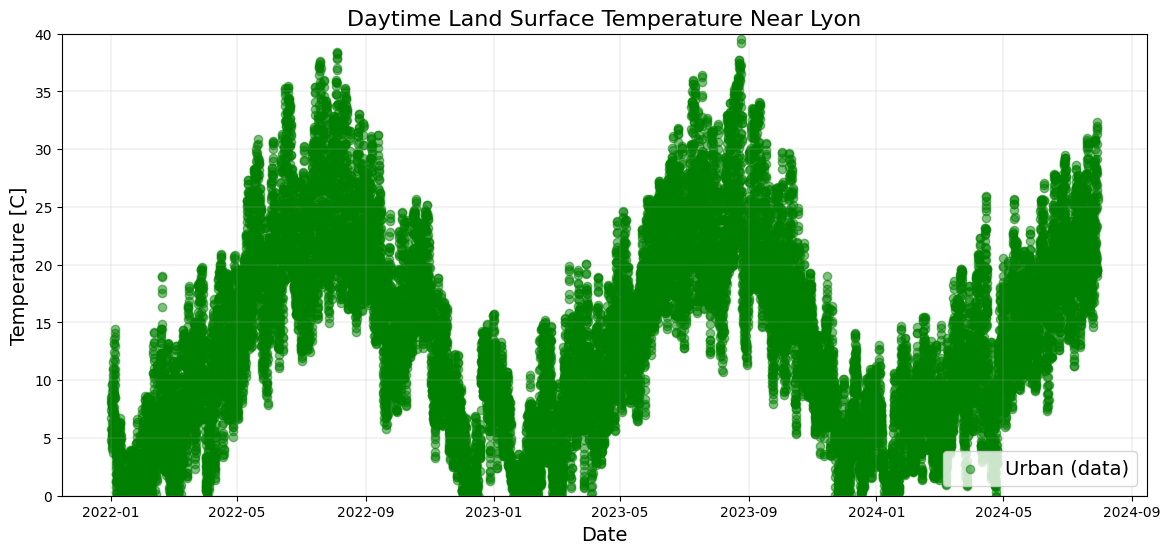

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
%matplotlib inline

# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_u = np.asanyarray(lst_df_urban['time'].apply(float))  # urban

## Secondly, extract y values (LST) from the dfs.
y_data_u = np.asanyarray(lst_df_urban['T10M'].apply(float))  # urban

## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

# params_u, params_covariance_u = optimize.curve_fit(
#     fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])

# # Subplots.
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plots.
ax.scatter(lst_df_urban['datetime'], lst_df_urban['T10M'],
            alpha=0.5, color='green', label='Urban (data)')

# Add fitting curves.
# ax.plot(lst_df_urban['datetime'],
#         fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
#         label='Urban (fitted)', color='black', lw=2.5)


# Add some parameters.
ax.set_title('Daytime Land Surface Temperature Near Lyon', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()